**Darius Parker**

**Eboni Mangum**

**Joshua Edwards**

**IST 718 Final Project**

**November 25, 2024**

***Please note that ChatGPT was used to assist with this notebook***

<font size="4"> This notebook is a group submission for the final project requirement of IST 718 (Big Data Analytics) at Syracuse University. The purpose of the notebook is to demonstrate techniques learned throughout the quarter using PySpark. The group chose to demonstrate this using a dataset from the latest NFL Big Data Bowl competition by Kaggle. Information regarding the tournament and dataset can be found at the link below:

<br>

<font size="4"> [https://www.kaggle.com/competitions/nfl-big-data-bowl-2025]<font size="4"> (https://www.kaggle.com/competitions/nfl-big-data-bowl-2025)  

<br>

<font size="4"> For this year’s competition, participants are asked to use the provided dataset to determine information related to pre-snap player and team tendencies. This notebook will focus on analyzing team tendencies specifically on third down plays. To achieve this, we will be using the `plays.csv` spreadsheet, which contains detailed information on each play, including down, distance, and contextual features. Our goal is to explore and extract meaningful insights into team behaviors and decision-making strategies on third down.  

</font>

<br>



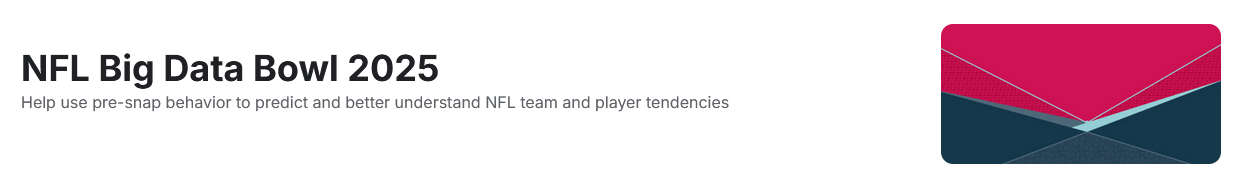

<font size="4">  
PySpark is highly beneficial for working with large datasets due to its distributed computing framework, which allows for efficient processing and analysis across multiple nodes. This is especially useful for datasets that exceed the memory capacity of a single machine, enabling users to scale their computations as needed.

<br>

<font size="4"> It is important to note that the dataset provided in this competition includes data only from the first nine weeks of the NFL season. In real-world scenarios, teams and analysts likley work with datasets containing years of data in order to capture historical performance and trends. Larger datasets can present significant computational challenges, particularly when performing complex aggregations and machine learning tasks. PySpark's ability to handle large datasets makes it an ideal tool for such research and analysis.

<br>

<font size="4"> To begin, install PySpark and import the required packages.
</font>


In [ ]:
!pip install pyspark

In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
# PySpark imports
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, sum, rand, when, count, lit, round, first, array, udf, expr, percentile_approx
)
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import (
    DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, RandomForestClassificationModel
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import functions as F
from functools import reduce  # Import reduce for combining columns

# External library imports
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import time  # For timing operations




# Start the timer
notebook_start_time = time.time()


<font size="4"> Create a spark session, load the plays.csv data set and get the number of rows/columns in the data set.

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("NFL Big Data Bowl Analysis").getOrCreate()
  # # Load data into PySpark

# Set PySpark global seed
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
seed = 42  # Set your seed value here
plays = spark.read.csv('plays.csv', header=True, inferSchema=True)

In [ ]:
# Get the number of rows
num_rows = plays.count()
# Get the number of columns
num_columns = len(plays.columns)
# Print the shape
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")

Shape of the DataFrame: (16124, 50)


<font size="4"> There are total of 16124 rows, which represent the number of plays in the data frame. There are also total 50 columns (features). Let's display the first five rows of the dataframe.

In [ ]:
# Display the first few rows for inspection
plays.show(5)

+----------+------+--------------------+-------+----+---------+--------------+-------------+------------+--------------+-------------------+----------------+-------------------+----------------------+----------------------+-----------------------------+--------------------------------+-----------------+----------------+-----------------+---------------+----------+----------+-------+-------+----------+------------+----------------+----------------+-----------+----------------+----------+----------------+-----------------+-------+-------+-------+----------------+------------+---------------------+-----------+---------------------------+----------------------------+-------------------+----------+---------------------+-----------------------+-----------------+----------------+-----------+
|    gameId|playId|     playDescription|quarter|down|yardsToGo|possessionTeam|defensiveTeam|yardlineSide|yardlineNumber|          gameClock|preSnapHomeScore|preSnapVisitorScore|playNullifiedByPenalty|abso

<font size="4"> We can also view each column name.

In [ ]:
# Print the column names
for column in plays.columns:
    print(column)

gameId
playId
playDescription
quarter
down
yardsToGo
possessionTeam
defensiveTeam
yardlineSide
yardlineNumber
gameClock
preSnapHomeScore
preSnapVisitorScore
playNullifiedByPenalty
absoluteYardlineNumber
preSnapHomeTeamWinProbability
preSnapVisitorTeamWinProbability
expectedPoints
offenseFormation
receiverAlignment
playClockAtSnap
passResult
passLength
targetX
targetY
playAction
dropbackType
dropbackDistance
passLocationType
timeToThrow
timeInTackleBox
timeToSack
passTippedAtLine
unblockedPressure
qbSpike
qbKneel
qbSneak
rushLocationType
penaltyYards
prePenaltyYardsGained
yardsGained
homeTeamWinProbabilityAdded
visitorTeamWinProbilityAdded
expectedPointsAdded
isDropback
pff_runConceptPrimary
pff_runConceptSecondary
pff_runPassOption
pff_passCoverage
pff_manZone


<font size="4"> Now, rather than showing the entire DataFrame at once, display the first 5 rows of each column separately. This gives a cleaner look at the data in each column.

<font size="4"> Get the number of unique games played in the data set. Recall that this is the first nine weeks of data in the 2022 season (i.e. the number of games from week one to week nine)

In [ ]:
# Get number of unique games based on gameId
unique_games = plays.select("gameId").distinct().count()
print(f"Total number of unique games: {unique_games}")

Total number of unique games: 136


<font size="4"> To get the number of run versus pass plays, we can use the 'isDropback' column. When this is equal to 'True', it is a passing play (and vice versa). Plays where isDropback is False and pff_runConceptPrimary is not null can be considered as run plays.

In [ ]:
# Count pass and run plays in the entire dataset
num_pass_plays = plays.filter(col("isDropback") == True).count()
num_run_plays = plays.filter((col("isDropback") == False) & (col("pff_runConceptPrimary").isNotNull())).count()

# Calculate total plays
total_plays = num_pass_plays + num_run_plays

# Calculate percentages
run_play_percentage = (num_run_plays / total_plays) * 100
pass_play_percentage = (num_pass_plays / total_plays) * 100

# Display the results
print("Number of pass plays:", num_pass_plays)
print("Number of run plays:", num_run_plays)
print(f"Percentage of run plays: {run_play_percentage:.2f}%")
print(f"Percentage of pass plays: {pass_play_percentage:.2f}%")

Number of pass plays: 9736
Number of run plays: 6388
Percentage of run plays: 39.62%
Percentage of pass plays: 60.38%


<font size="4"> Overall, teams run the ball about 40% of the time, and pass 60% of the time.

<font size="4"> Recall that for this project, we are interested in finding actionable insights only for third-down. Let's find the percentage of run and pass plays for third down only.

In [ ]:
# Filter for 3rd down plays
third_down_plays = plays.filter(col("down") == 3)

# Count total, pass, and run plays for 3rd down
num_third_down_pass_plays = third_down_plays.filter(col("isDropback") == True).count()
num_third_down_run_plays = third_down_plays.filter((col("isDropback") == False) & (col("pff_runConceptPrimary").isNotNull())).count()

# Calculate total 3rd down plays
total_third_down_plays = num_third_down_pass_plays + num_third_down_run_plays

# Calculate percentages
third_down_run_play_percentage = (num_third_down_run_plays / total_third_down_plays) * 100
third_down_pass_play_percentage = (num_third_down_pass_plays / total_third_down_plays) * 100

# Display the results
print("Number of 3rd down pass plays:", num_third_down_pass_plays)
print("Number of 3rd down run plays:", num_third_down_run_plays)
print(f"Percentage of 3rd down run plays: {third_down_run_play_percentage:.2f}%")
print(f"Percentage of 3rd down pass plays: {third_down_pass_play_percentage:.2f}%")

Number of 3rd down pass plays: 2624
Number of 3rd down run plays: 655
Percentage of 3rd down run plays: 19.98%
Percentage of 3rd down pass plays: 80.02%


<font size="4"> This shows that league wide, teams tend to run the ball about 20% of the time on third down, and pass 80% on third down. It could be advantageous however, to get the stats for each individual team. Not only could it be advantageous to have this information for an opponent, it may be good practice for teams to have this information for their own team to perhaps avoid predictable tendencies.

In [ ]:
# Calculate stats for each team on 3rd down plays
team_stats = third_down_plays.groupBy("possessionTeam").agg(
    count(when(col("isDropback") == True, True)).alias("Pass Plays"),
    count(when((col("isDropback") == False) & (col("pff_runConceptPrimary").isNotNull()), True)).alias("Run Plays")
)

# Add column for total plays
team_stats = team_stats.withColumn("Total Plays", col("Pass Plays") + col("Run Plays"))

# Calculate percentage of run plays and percentage of pass plays
team_stats = team_stats.withColumn("Run Play Percentage", (col("Run Plays") / col("Total Plays")) * 100)
team_stats = team_stats.withColumn("Pass Play Percentage", (col("Pass Plays") / col("Total Plays")) * 100)

# Sort by Run Play Percentage in descending order
team_stats = team_stats.orderBy(col("Run Play Percentage").desc())

print('Displaying run vs. pass percentange on third down by team...')
# Display the sorted stats
team_stats.select("possessionTeam", "Total Plays", "Pass Plays", "Run Plays", "Run Play Percentage", "Pass Play Percentage").show(team_stats.count())

Displaying run vs. pass percentange on third down by team...
+--------------+-----------+----------+---------+-------------------+--------------------+
|possessionTeam|Total Plays|Pass Plays|Run Plays|Run Play Percentage|Pass Play Percentage|
+--------------+-----------+----------+---------+-------------------+--------------------+
|           PHI|        102|        61|       41|  40.19607843137255|   59.80392156862745|
|           CHI|        115|        78|       37|  32.17391304347826|   67.82608695652173|
|           BAL|        106|        74|       32|  30.18867924528302|   69.81132075471697|
|           DAL|         94|        68|       26| 27.659574468085108|    72.3404255319149|
|           CAR|         95|        69|       26| 27.368421052631582|   72.63157894736842|
|           JAX|        103|        75|       28| 27.184466019417474|   72.81553398058253|
|            NE|        108|        79|       29| 26.851851851851855|   73.14814814814815|
|           ATL|         98| 

<font size="4"> The Philadelphia Eagles run the ball at the highest rate on third down at around 40%, while the Pittsburgh Steelers have the lowest run rate on third down at 7.8%. This can also be visualized using a chart.

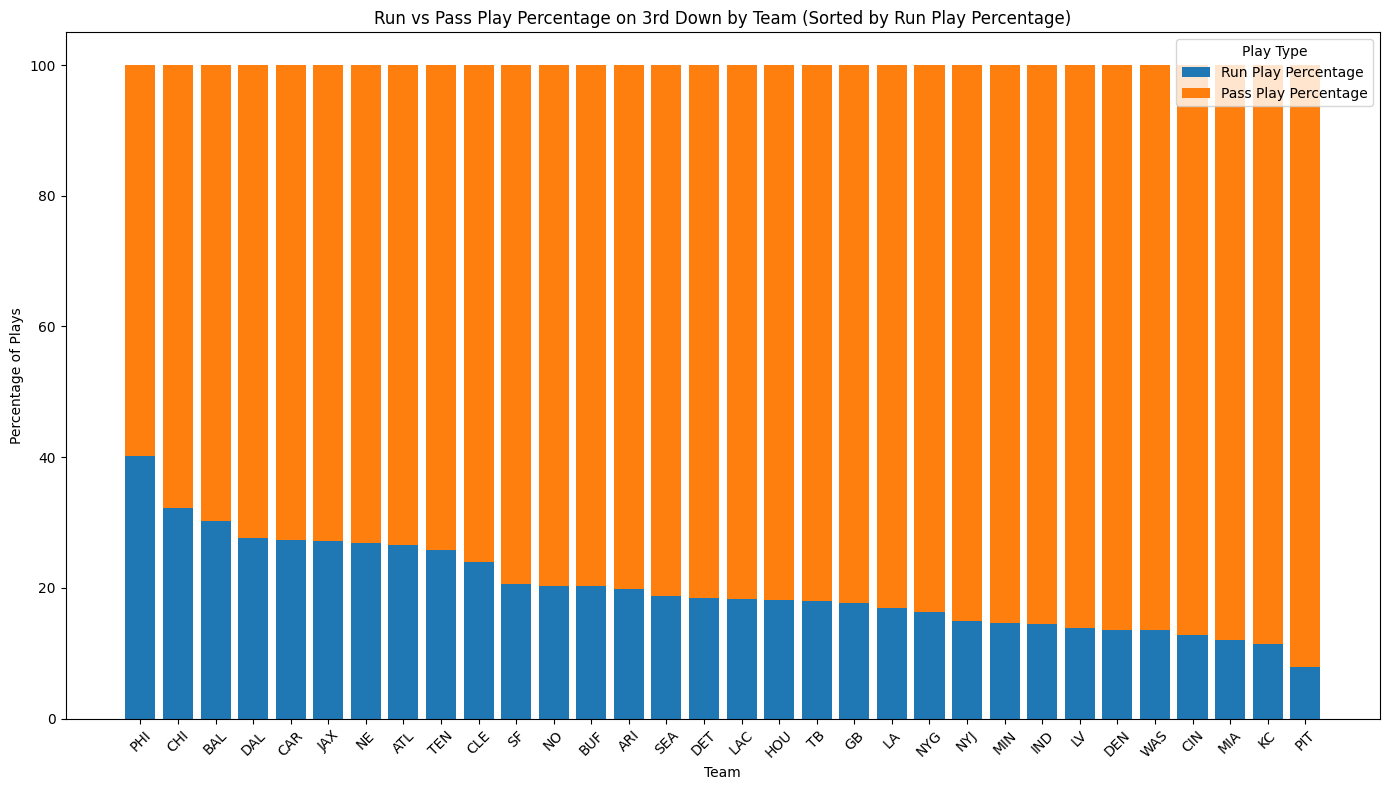

In [ ]:
# Collect data for plotting
data = team_stats.select("possessionTeam", "Run Play Percentage", "Pass Play Percentage").collect()

# Extract data for plotting
teams = [row["possessionTeam"] for row in data]
run_play_percentages = [row["Run Play Percentage"] for row in data]
pass_play_percentages = [row["Pass Play Percentage"] for row in data]

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Plot run and pass play percentages
ax.bar(teams, run_play_percentages, label="Run Play Percentage")
ax.bar(teams, pass_play_percentages, bottom=run_play_percentages, label="Pass Play Percentage")

# Set chart title and labels
plt.title("Run vs Pass Play Percentage on 3rd Down by Team (Sorted by Run Play Percentage)")
plt.xlabel("Team")
plt.ylabel("Percentage of Plays")
plt.xticks(rotation=45)
plt.legend(title="Play Type")
plt.tight_layout()
plt.show()

<font size="4"> Next, we can group by the number of yards until the first down for each run/pass percentage. First, do this for all teams league wide.

In [ ]:
# Group by modified 'yardsToGo' where values > 15 are labeled as "15+"
yards_to_go_stats = third_down_plays.withColumn(
    "yardsToGoCategory", when(col("yardsToGo") > 15, "15+").otherwise(col("yardsToGo").cast("string"))
).withColumn(
    "yardsToGoOrder", when(col("yardsToGo") > 15, 16).otherwise(col("yardsToGo"))  # For sorting purposes
).groupBy("yardsToGoCategory", "yardsToGoOrder").agg(
    count(when(col("isDropback") == True, True)).alias("Pass Plays"),
    count(when((col("isDropback") == False) & (col("pff_runConceptPrimary").isNotNull()), True)).alias("Run Plays")
)

# Calculate total plays
yards_to_go_stats = yards_to_go_stats.withColumn("Total Plays", col("Pass Plays") + col("Run Plays"))

# Calculate run and pass play percentages
yards_to_go_stats = yards_to_go_stats.withColumn("Run Play Percentage", (col("Run Plays") / col("Total Plays")) * 100)
yards_to_go_stats = yards_to_go_stats.withColumn("Pass Play Percentage", (col("Pass Plays") / col("Total Plays")) * 100)

# Sort by 'yardsToGoOrder' to ensure numerical order with "15+" at the end
yards_to_go_stats = yards_to_go_stats.orderBy("yardsToGoOrder")

print('Displaying run vs. pass percentange on third down by yards to go (all teams)...')
# Display the results
yards_to_go_stats.select("yardsToGoCategory", "Total Plays", "Pass Plays", "Run Plays", "Run Play Percentage", "Pass Play Percentage").show()

Displaying run vs. pass percentange on third down by yards to go (all teams)...
+-----------------+-----------+----------+---------+-------------------+--------------------+
|yardsToGoCategory|Total Plays|Pass Plays|Run Plays|Run Play Percentage|Pass Play Percentage|
+-----------------+-----------+----------+---------+-------------------+--------------------+
|                1|        411|       111|      300|  72.99270072992701|   27.00729927007299|
|                2|        284|       184|      100|   35.2112676056338|    64.7887323943662|
|                3|        256|       196|       60|            23.4375|             76.5625|
|                4|        271|       245|       26|   9.59409594095941|   90.40590405904058|
|                5|        313|       284|       29|   9.26517571884984|   90.73482428115017|
|                6|        236|       217|       19|  8.050847457627118|   91.94915254237289|
|                7|        244|       222|       22|   9.01639344262295|  

<font size="4"> It appears that the percentage of pass plays 'jump' to more than 90% if the team has four or more yards to go. Let's do the same for each team individually.

In [ ]:
# Group by team and modified 'yardsToGo' where values > 15 are labeled as "15+"
team_yards_to_go_stats = third_down_plays.withColumn(
    "yardsToGoCategory", when(col("yardsToGo") > 15, "15+").otherwise(col("yardsToGo").cast("string"))
).withColumn(
    "yardsToGoOrder", when(col("yardsToGo") > 15, 16).otherwise(col("yardsToGo"))  # For sorting purposes
).groupBy("possessionTeam", "yardsToGoCategory", "yardsToGoOrder").agg(
    count(when((col("isDropback") == False) & (col("pff_runConceptPrimary").isNotNull()), True)).alias("Run Plays"),
    count("*").alias("Total Plays")
)

# Calculate the Run Play Percentage with PySpark round function
team_yards_to_go_stats = team_yards_to_go_stats.withColumn(
    "Run Play Percentage", round((col("Run Plays") / col("Total Plays")) * 100, 2)
)

# Pivot the data to have one column per team
pivot_df = team_yards_to_go_stats.groupBy("yardsToGoCategory", "yardsToGoOrder").pivot("possessionTeam").agg(
    first("Run Play Percentage")
).orderBy("yardsToGoOrder")  # Order by the numeric sorting column

# Drop the sorting column for display
pivot_df = pivot_df.drop("yardsToGoOrder")

print('Displaying run percentage by yardsToGoCategory on third down (all teams)...')
# Show the result
pivot_df.show(truncate=False)

Displaying run percentage by yardsToGoCategory on third down (all teams)...
+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+
|yardsToGoCategory|ARI  |ATL  |BAL  |BUF  |CAR  |CHI  |CIN  |CLE  |DAL  |DEN  |DET  |GB   |HOU  |IND  |JAX  |KC   |LA   |LAC  |LV   |MIA  |MIN  |NE   |NO   |NYG  |NYJ  |PHI  |PIT |SEA  |SF   |TB   |TEN  |WAS  |
+-----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+
|1                |84.62|88.24|89.47|62.5 |85.71|90.0 |61.11|71.43|93.33|69.23|57.14|53.85|78.57|80.0 |84.21|37.5 |42.86|73.33|71.43|72.73|60.0 |60.0 |87.5 |66.67|53.85|93.33|87.5|60.0 |77.78|88.24|83.33|58.33|
|2                |12.5 |40.0 |88.89|0.0  |33.33|71.43|0.0  |57.14|66.67|11.11|3

<font size="4"> To this point, the data has been viewed for all teams in the league. It is more likely however, that teams will focus only on the metrics for an opponent for the next upcoming game (or perhaps their own team metrics). For this example, we will take the position as a coach for the Seattle Seahawks. We will use the Philadelphia (PHI) Eagles as an example for the next upcomiming opponent. Lets get the same chart above for the PHI Eagles only.

In [ ]:
# Filter to include only the OPP in the analysis
opp_yards_to_go_stats = team_yards_to_go_stats.filter(col("possessionTeam") == "PHI")

# Pivot the data for OPP only by yardsToGoCategory with Run Play Percentage
opp_pivot_df = opp_yards_to_go_stats.groupBy("yardsToGoCategory", "yardsToGoOrder").agg(
    first("Run Play Percentage").alias("OPP_Run%")
).orderBy("yardsToGoOrder").drop("yardsToGoOrder")  # Sort by yardsToGoOrder and drop it after sorting

print('Displaying run percentage by yardsToGoCategory on third down (New York Giants)...')
# Show the result for OPP
opp_pivot_df.show(truncate=False)

Displaying run percentage by yardsToGoCategory on third down (New York Giants)...
+-----------------+--------+
|yardsToGoCategory|OPP_Run%|
+-----------------+--------+
|1                |93.33   |
|2                |63.64   |
|3                |55.56   |
|4                |28.57   |
|5                |27.27   |
|6                |37.5    |
|7                |20.0    |
|8                |0.0     |
|9                |0.0     |
|10               |0.0     |
|11               |0.0     |
|12               |0.0     |
|13               |0.0     |
|14               |50.0    |
|15               |33.33   |
|15+              |50.0    |
+-----------------+--------+



<font size="4"> The Philadelphia Eagles has a more balanced approach on third down than the majority of teams. Let’s see if machine learning can be used to help predict the third-down tendencies of PHI.

# Machine Learning

<font size="4"> For the analysis, a new column is created “isRun.” Plays in which a team run the ball will be labeled with a 1, and will be labeled with a 0 for pass plays.


   
<font size="4"> Although there are 50 columns included in the dataset, few are useful in the context of using the information pre-snap to predict run vs pass plays on third down. In this context, only four variables could be useful for this:

   - **`absoluteYardlineNumber`**:  
     - Represents the distance from the end zone for the possession team.  
     
   - **`offenseFormation`**:  
     - Specifies the formation used by the possession team (e.g., Shotgun, I-Formation).  
   
   - **`receiverAlignment`**:  
     - Enumerates the alignment of receivers, such as 0x0, 1x0, 1x1, 2x0, 2x1, 2x2, 3x0, 3x1, 3x2.  
  
   - **`yardsToGo`**:  
      - Number of yards until a first down.
    

In [ ]:
columns = ["possessionTeam", "yardsToGo", "absoluteYardlineNumber", "offenseFormation", "receiverAlignment", "isRun"]

# Create target column: 'isRun' (1 for run, 0 for pass)
plays = plays.withColumn(
    "isRun", when(col("isDropback") == False, 1).otherwise(0)
)
third_down_plays = plays.filter(col("down") == 3)

In [ ]:
third_down_plays.select(columns).show(truncate=False)

+--------------+---------+----------------------+----------------+-----------------+-----+
|possessionTeam|yardsToGo|absoluteYardlineNumber|offenseFormation|receiverAlignment|isRun|
+--------------+---------+----------------------+----------------+-----------------+-----+
|HOU           |12       |30                    |SHOTGUN         |2x2              |0    |
|ARI           |12       |82                    |NA              |NA               |1    |
|PHI           |12       |45                    |SHOTGUN         |3x1              |0    |
|DAL           |8        |45                    |SHOTGUN         |3x1              |0    |
|DAL           |5        |95                    |SHOTGUN         |2x2              |0    |
|CIN           |6        |30                    |SHOTGUN         |3x1              |0    |
|NE            |6        |77                    |SHOTGUN         |2x2              |0    |
|IND           |6        |36                    |SHOTGUN         |3x1              |0    |

We would like to determine if machine learning can be used to help predict run vs pass on third down for PHI only. This presents a dilemma however. While it is logical to attempt to train a model based on a single opponent's tendencies, attempting to predict third down outcomes using the third down plays from only one team could yield a data set that is too small for training. Let's look at the count of PHI Eagles third down plays for this example.

In [ ]:
# Filter third-down plays for the Opposing Team
opp_third_down_plays = third_down_plays.filter(col("possessionTeam") == "PHI")

# Create target column: 'isRun' (1 for run, 0 for pass)
opp_third_down_plays = opp_third_down_plays.withColumn(
    "isRun", when(col("isDropback") == False, 1).otherwise(0)
)

In [ ]:
# Select only the relevant columns and target
opp_relevant_data = opp_third_down_plays.select(
   "possessionTeam", "yardsToGo","absoluteYardlineNumber", "offenseFormation", "receiverAlignment", "isRun"
)

# Show the first few rows of the filtered DataFrame
opp_relevant_data.show(5, truncate=False)

# Get the count of rows and columns
num_rows = opp_relevant_data.count()
num_columns = len(opp_relevant_data.columns)

# Print the results
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

+--------------+---------+----------------------+----------------+-----------------+-----+
|possessionTeam|yardsToGo|absoluteYardlineNumber|offenseFormation|receiverAlignment|isRun|
+--------------+---------+----------------------+----------------+-----------------+-----+
|PHI           |12       |45                    |SHOTGUN         |3x1              |0    |
|PHI           |16       |26                    |SHOTGUN         |2x2              |1    |
|PHI           |14       |46                    |SHOTGUN         |2x2              |0    |
|PHI           |3        |66                    |SHOTGUN         |3x1              |1    |
|PHI           |20       |52                    |SHOTGUN         |2x2              |0    |
+--------------+---------+----------------------+----------------+-----------------+-----+
only showing top 5 rows

Number of rows: 102
Number of columns: 6


In [ ]:
# Count the number of run (isRun = 1) and pass (isRun = 0) plays
run_pass_counts = opp_relevant_data.groupBy("isRun").count()

# Show the counts
run_pass_counts.show()

+-----+-----+
|isRun|count|
+-----+-----+
|    1|   41|
|    0|   61|
+-----+-----+



The Philadelphia Eagles have a total of 102 plays on third down (41 runs, and 61 passes)

In [ ]:
third_down_plays.count()

3279

In [ ]:
# Count the number of run (isRun = 1) and pass (isRun = 0) plays
run_pass_counts = third_down_plays.groupBy("isRun").count()

# Show the counts
run_pass_counts.show()

+-----+-----+
|isRun|count|
+-----+-----+
|    1|  655|
|    0| 2624|
+-----+-----+



Alternativley, there are 3270 third down plays league wide (655 runs to 2624 passes). For this reason, we will use a training set that includes third down plays for all teams rather than just the upcoming opponent.

**Class Weights**

Class weights will be used given the imbalance of runs vs. passes. Oversampling or undersampling techniques could be an alternative for this, however our preference is to use class weights rather than a techinque such as oversampling. Artificially altering the dataset could alter the integreity of the data, and could potentially cause overfitting.

In [ ]:
def apply_class_weights(df: DataFrame, label_col: str, weight_col: str = "classWeight") -> DataFrame:

    if "classWeight" in df.columns:
      df = df.drop("classWeight")

    # Get total samples and class counts
    total_samples = df.count()
    class_counts = df.groupBy(label_col).count().collect()

    # Calculate the number of unique classes
    num_classes = len(class_counts)

    # Compute class weights dynamically
    class_weights = {
        row[label_col]: total_samples / (num_classes * row["count"]) for row in class_counts
    }

    # Initialize the class weight column
    df = df.withColumn(weight_col, lit(0))

    # Apply class weights dynamically
    for label, weight in class_weights.items():
        df = df.withColumn(
            weight_col,
            when(col(label_col) == label, lit(weight)).otherwise(col(weight_col))
        )

    # Display the computed class weights
    print("Computed Class Weights:")
    for label, weight in class_weights.items():
        print(f"Label {label}: Weight = {weight:.4f}")

    return df


In [ ]:
# Apply class weights to the 'isRun' column
third_down_plays = apply_class_weights(third_down_plays, label_col="isRun", weight_col="classWeight")

#Display the dataframe with column for class weights
third_down_plays.select("possessionTeam", "absoluteYardlineNumber", "offenseFormation", "receiverAlignment", "yardsToGo", "isRun", "classWeight").show(5)

Computed Class Weights:
Label 1: Weight = 2.5031
Label 0: Weight = 0.6248
+--------------+----------------------+----------------+-----------------+---------+-----+------------------+
|possessionTeam|absoluteYardlineNumber|offenseFormation|receiverAlignment|yardsToGo|isRun|       classWeight|
+--------------+----------------------+----------------+-----------------+---------+-----+------------------+
|           HOU|                    30|         SHOTGUN|              2x2|       12|    0|0.6248094512195121|
|           ARI|                    82|              NA|               NA|       12|    1| 2.503053435114504|
|           PHI|                    45|         SHOTGUN|              3x1|       12|    0|0.6248094512195121|
|           DAL|                    45|         SHOTGUN|              3x1|        8|    0|0.6248094512195121|
|           DAL|                    95|         SHOTGUN|              2x2|        5|    0|0.6248094512195121|
+--------------+----------------------+-------

To prepare categorical variables (offenseFormation and receiverAlignment) for machine learning models, we need to encode them into numeric formats suitable for computation. The function below achieves this using PySpark's tools.
What the Code Does

**String Indexing:**
Converts categorical text columns into numeric indices using StringIndexer.

**One-Hot Encoding:**
Converts these indices into sparse one-hot vectors with OneHotEncoder, ensuring efficient representation without introducing ordinal relationships.

**Feature Assembly:**
Combines one-hot encoded vectors with other numerical features (absoluteYardlineNumber and yardsToGo) into a unified feature vector using VectorAssembler. This ensures compatibility with machine learning algorithms.

In [ ]:
def preprocess_features(df, categorical_cols, numerical_cols, output_feature_col="features"):
    # Drop the output feature column if it exists
    if output_feature_col in df.columns:
        df = df.drop(output_feature_col)

    for col_name in categorical_cols:
        # Drop existing index and vector columns for this categorical column
        index_col = f"{col_name}Index"
        vec_col = f"{col_name}Vec"

        if index_col in df.columns:
            df = df.drop(index_col)
        if vec_col in df.columns:
            df = df.drop(vec_col)

        # String Indexer for categorical column
        indexer = StringIndexer(inputCol=col_name, outputCol=index_col)
        df = indexer.fit(df).transform(df)

        # OneHotEncoder for indexed categorical column
        encoder = OneHotEncoder(inputCol=index_col, outputCol=vec_col)
        df = encoder.fit(df).transform(df)

    # Assemble features into a single vector
    assembler = VectorAssembler(
        inputCols=[f"{col_name}Vec" for col_name in categorical_cols] + numerical_cols,
        outputCol=output_feature_col
    )
    df = assembler.transform(df)

    return df

In [ ]:
# Categorical and numerical columns
categorical_columns = ["offenseFormation", "receiverAlignment"]
numerical_columns = ["absoluteYardlineNumber", "yardsToGo"]
# Preprocess `third_down_plays` DataFrame
third_down_plays = preprocess_features(third_down_plays, categorical_columns, numerical_columns)

In [ ]:
# Display the updated DataFrame
third_down_plays.select("absoluteYardlineNumber", "offenseFormationVec", "receiverAlignmentVec", "yardsToGo", "features", "isRun", "classWeight").show(5)

+----------------------+-------------------+--------------------+---------+--------------------+-----+------------------+
|absoluteYardlineNumber|offenseFormationVec|receiverAlignmentVec|yardsToGo|            features|isRun|       classWeight|
+----------------------+-------------------+--------------------+---------+--------------------+-----+------------------+
|                    30|      (7,[0],[1.0])|      (10,[1],[1.0])|       12|(19,[0,8,17,18],[...|    0|0.6248094512195121|
|                    82|      (7,[6],[1.0])|      (10,[6],[1.0])|       12|(19,[6,13,17,18],...|    1| 2.503053435114504|
|                    45|      (7,[0],[1.0])|      (10,[0],[1.0])|       12|(19,[0,7,17,18],[...|    0|0.6248094512195121|
|                    45|      (7,[0],[1.0])|      (10,[0],[1.0])|        8|(19,[0,7,17,18],[...|    0|0.6248094512195121|
|                    95|      (7,[0],[1.0])|      (10,[1],[1.0])|        5|(19,[0,8,17,18],[...|    0|0.6248094512195121|
+----------------------+

Ensure there are no missing values in the selected feature columns.

In [ ]:
def check_missing_values(df, columns):
    # Check for missing values in the specified columns
    missing_values = df.select(
        [(sum(col(column).isNull().cast("int")).alias(column)) for column in columns]
    )

    # Display the result
    print("Missing Values:")
    missing_values.show()


In [ ]:
# Define the columns to check
df_columns = ["possessionTeam", "absoluteYardlineNumber", "offenseFormationVec",
                    "receiverAlignmentVec", "yardsToGo", "isRun", "classWeight", "features"]

# Check missing values for 'plays' DataFrame
check_missing_values(third_down_plays, df_columns)

Missing Values:
+--------------+----------------------+-------------------+--------------------+---------+-----+-----------+--------+
|possessionTeam|absoluteYardlineNumber|offenseFormationVec|receiverAlignmentVec|yardsToGo|isRun|classWeight|features|
+--------------+----------------------+-------------------+--------------------+---------+-----+-----------+--------+
|             0|                     0|                  0|                   0|        0|    0|          0|       0|
+--------------+----------------------+-------------------+--------------------+---------+-----+-----------+--------+



**Outlier removal**

It is likely that teams would not run the ball in 'third and long' situations. We removed the upper bound '80th percentile' from the data set which represents plays of third and 10 or longer.

In [ ]:
# Calculate the 10th and 90th percentiles
quantiles = third_down_plays.select(
    percentile_approx(col("yardsToGo"), [0.10, 0.80]).alias("quantiles")
).collect()[0]["quantiles"]

# Extract the lower (10th) and upper (90th) quantile values
lower_bound = quantiles[0]
upper_bound = quantiles[1]

print(f"Lower Bound (10th Percentile): {lower_bound}")
print(f"Upper Bound (80th Percentile): {upper_bound}")

# Filter out rows above the upper quantile and retain the name third_down_plays
third_down_plays = third_down_plays.filter(col("yardsToGo") <= upper_bound)

Lower Bound (10th Percentile): 1
Upper Bound (80th Percentile): 10


In [ ]:
print(f"Number of rows after filtering: {third_down_plays.count()}")

Number of rows after filtering: 2684


The dataset is shuffled to randomize the order of rows, ensuring that the split into training and testing sets is unbiased. The data is then split into an 80% training set and a 20% testing set using the `randomSplit` method.


In [ ]:
def shuffle_and_split_data(df: DataFrame, train_ratio: float = 0.8, seed: int = 42) -> tuple:
    # Shuffle the DataFrame by adding a random column and ordering by it
    shuffled_data = df.withColumn("random", rand(seed)).orderBy("random").drop("random")

    # Split the shuffled data into training and test sets
    train_data, test_data = shuffled_data.randomSplit([train_ratio, 1 - train_ratio], seed=seed)

    return train_data, test_data


In [ ]:
# Shuffle and split the data
train_data, test_data = shuffle_and_split_data(third_down_plays, train_ratio=0.8, seed=42)
# Display a few rows from the training and test sets
print('Train data...')
train_data.select('features').show(5)
print('Test data...')
test_data.select('features').show(5)

Train data...
+--------------------+
|            features|
+--------------------+
|(19,[3,10,17,18],...|
|(19,[0,7,17,18],[...|
|(19,[1,9,17,18],[...|
|(19,[0,8,17,18],[...|
|(19,[0,7,17,18],[...|
+--------------------+
only showing top 5 rows

Test data...
+--------------------+
|            features|
+--------------------+
|(19,[0,8,17,18],[...|
|(19,[0,7,17,18],[...|
|(19,[2,7,17,18],[...|
|(19,[0,7,17,18],[...|
|(19,[0,7,17,18],[...|
+--------------------+
only showing top 5 rows



#### **Parameter tuning**

A grid search was performed to find the best parameters for the model. Detailed information about the parameters of the model can be found in the pyspark documentation for this model:

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html

#### Training and Evaluating Models

A function is defined to train and evaluate multiple machine learning models on the training and testing datasets. The models include Decision Tree, Random Forest, Logistic Regression, and Gradient Boosted Trees. A classification report is printed for each model.

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Define a Decision Tree Classifier
dec_tree = DecisionTreeClassifier(featuresCol="features", labelCol="isRun", predictionCol="prediction", weightCol="classWeight", maxDepth=10, minInstancesPerNode=5)

# Define a Random Forest Classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="isRun", predictionCol="prediction", weightCol="classWeight", numTrees=50, maxDepth=20)

# Define a Logistic Regression model
log_reg = LogisticRegression(featuresCol="features", labelCol="isRun", predictionCol="prediction", weightCol="classWeight", regParam=0.01, elasticNetParam=0.0)

# Define a Gradient-Boosted Tree Classifier
gbt_classifier = GBTClassifier(featuresCol="features", labelCol="isRun", predictionCol="prediction", weightCol="classWeight", maxDepth=5, maxIter=50, stepSize=0.2)

input_size = train_data.select("features").first()["features"].size

# Add MLP to the model list and names
mlp = MultilayerPerceptronClassifier(
    labelCol="isRun",
    featuresCol="features",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    maxIter=100,
    layers=[input_size, 256, 128, 64, 32, 16, 2],
    blockSize=128,
    seed=seed
)


In [ ]:
def train_and_evaluate_models(models: list, model_names: list, train_data: DataFrame, test_data: DataFrame, label_col: str, class_weight: bool, prediction_col: str = "prediction"):
    if len(models) != len(model_names):
        raise ValueError("The number of models must match the number of model names.")

    trained_models = {}

    for model, name in zip(models, model_names):
        print(f"Training {name}...")

        # Apply class weight only if specified and the model supports it
        if class_weight and hasattr(model, "setWeightCol"):
            model = model.setWeightCol("classWeight")
        elif hasattr(model, "setWeightCol"):
            model = model.setWeightCol(None)  # Clear weightCol if class_weight is False

        # Train the model
        trained_model = model.fit(train_data)
        trained_models[name] = trained_model

        # Make predictions
        predictions = trained_model.transform(test_data)

        # Convert predictions to Pandas for evaluation
        y_true = predictions.select(label_col).toPandas()[label_col].tolist()
        y_pred = predictions.select(prediction_col).toPandas()[prediction_col].tolist()

        # Generate the classification report
        report = classification_report(y_true, y_pred, output_dict=False)
        print(f"\nClassification Report for {name}:\n")
        print(report)

    return trained_models



In [ ]:
# Define models and their names
models = [dec_tree, rf_classifier, log_reg, gbt_classifier, mlp]
model_names = ["Decision Tree", "Random Forest", "Logistic Regression", "GBT", "MLP"]

label_col = "isRun"

# Train and evaluate models
trained_models = train_and_evaluate_models(models, model_names, train_data, test_data, label_col, class_weight=True)

Training Decision Tree...

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       375
           1       0.58      0.76      0.66       118

    accuracy                           0.81       493
   macro avg       0.75      0.79      0.76       493
weighted avg       0.84      0.81      0.82       493

Training Random Forest...

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       375
           1       0.66      0.77      0.71       118

    accuracy                           0.85       493
   macro avg       0.79      0.82      0.80       493
weighted avg       0.86      0.85      0.85       493

Training Logistic Regression...

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       375
           1      

#Ensemble

The models are ensembed using a majority voting method.

In [ ]:
# Generate predictions for all models with distinct column names
def get_predictions_with_column(model, test_data, target, model_name):
    predictions = model.transform(test_data).select(
        "features", target, col("prediction").alias(model_name)
    )
    return predictions

# Get predictions for all models, including MLP
rf_predictions = get_predictions_with_column(trained_models["Random Forest"], test_data, "isRun", "rf_prediction")
dt_predictions = get_predictions_with_column(trained_models["Decision Tree"], test_data, "isRun", "dt_prediction")
lr_predictions = get_predictions_with_column(trained_models["Logistic Regression"], test_data, "isRun", "lr_prediction")
gbt_predictions = get_predictions_with_column(trained_models["GBT"], test_data, "isRun", "gbt_prediction")
mlp_predictions = get_predictions_with_column(trained_models["MLP"], test_data, "isRun", "mlp_prediction")

# Combine predictions from all models
combined_predictions = rf_predictions.join(dt_predictions, ["features", "isRun"], "inner") \
                                      .join(lr_predictions, ["features", "isRun"], "inner") \
                                      .join(gbt_predictions, ["features", "isRun"], "inner") \
                                      .join(mlp_predictions, ["features", "isRun"], "inner")

# Update majority voting logic to include MLP
def majority_vote_with_mlp(df):
    return df.withColumn(
        "final_prediction",
        when(
            (col("rf_prediction") + col("dt_prediction") + col("lr_prediction") + col("gbt_prediction") + col("mlp_prediction")) > 2, 1
        ).otherwise(0)
    )

# Apply majority voting
ensemble_predictions = majority_vote_with_mlp(combined_predictions)

# Evaluate ensemble predictions
ensemble_predictions_pandas = ensemble_predictions.select("isRun", "final_prediction").toPandas()
y_true_ensemble = ensemble_predictions_pandas["isRun"].tolist()
y_pred_ensemble = ensemble_predictions_pandas["final_prediction"].tolist()

print("\nClassification Report for Ensemble Model (with MLP):\n")
print(classification_report(y_true_ensemble, y_pred_ensemble))

# Show sample predictions
ensemble_predictions.select(
    "features", "isRun", "rf_prediction", "dt_prediction", "lr_prediction", "gbt_prediction", "mlp_prediction", "final_prediction"
).show(10)


Classification Report for Ensemble Model (with MLP):

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3375
           1       0.80      0.87      0.83       208

    accuracy                           0.98      3583
   macro avg       0.89      0.93      0.91      3583
weighted avg       0.98      0.98      0.98      3583

+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|            features|isRun|rf_prediction|dt_prediction|lr_prediction|gbt_prediction|mlp_prediction|final_prediction|
+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|(19,[0,8,17,18],[...|    0|          0.0|          0.0|          0.0|           0.0|           0.0|               0|
|(19,[0,7,17,18],[...|    0|          0.0|          0.0|          0.0|           0.0|           0.0|               0|
|(19,[2,7,17,18],[...|    0|

**Performance Summary**:  
All models performed well in predicting Class 0 (pass plays), with high precision, recall, and F1-scores.

Predicting Class 1 (run plays) proved more challenging, as evidenced by lower precision and recall across all models. This reflects the inherent class imbalance and the more complex nature of identifying run plays.

Altough the models do not do well individually, the ensemble model has 'decent' results predicting runs, with a F1 score of .83 for the run category.


**Feature Importance**

The feature importance of each model is displayed below.

In [ ]:
def compute_feature_importance_separate(models, model_names, feature_cols):

    if len(models) != len(model_names):
        raise ValueError("The number of models must match the number of model names.")

    feature_importance_dfs = {}

    for model, model_name in zip(models, model_names):
        if model_name == 'MLP':
          continue
        if hasattr(model, "featureImportances"):
            # Tree-based models (Decision Tree, Random Forest, GBT)
            importances = model.featureImportances.toArray()
        elif hasattr(model, "coefficients"):
            # Logistic Regression
            importances = model.coefficients.toArray()
            # Take absolute values for importance
            importances = [abs(coef) for coef in importances]
        else:
            raise ValueError(f"The model '{model_name}' does not support feature importance.")

        # Create tuples of feature name and importance
        model_importances = [(feature, float(importance)) for feature, importance in zip(feature_cols, importances)]

        # Define schema for the resulting DataFrame
        schema = StructType([
            StructField("feature", StringType(), True),
            StructField("importance", FloatType(), True)
        ])

        # Create PySpark DataFrame
        importance_df = spark.createDataFrame(model_importances, schema=schema)

        # Sort by importance in descending order
        sorted_df = importance_df.orderBy(F.col("importance").desc())
        feature_importance_dfs[model_name] = sorted_df

    return feature_importance_dfs




In [ ]:
# Extract models and their names
model_list = list(trained_models.values())
model_names = list(trained_models.keys())

# Original feature columns
feature_list = ["absoluteYardlineNumber", "offenseFormationVec", "receiverAlignmentVec", "yardsToGo"]

# Compute feature importances for each model
feature_importances_per_model = compute_feature_importance_separate(model_list, model_names, feature_list)

# Display feature importances for each model
for model_name, importance_df in feature_importances_per_model.items():
    print(f"Feature Importances for {model_name}:")
    importance_df.show(truncate=False)


Feature Importances for Decision Tree:
+----------------------+-----------+
|feature               |importance |
+----------------------+-----------+
|receiverAlignmentVec  |0.097087294|
|yardsToGo             |0.03227755 |
|absoluteYardlineNumber|0.027188059|
|offenseFormationVec   |0.01622022 |
+----------------------+-----------+

Feature Importances for Random Forest:
+----------------------+-----------+
|feature               |importance |
+----------------------+-----------+
|absoluteYardlineNumber|0.12781663 |
|receiverAlignmentVec  |0.110342205|
|offenseFormationVec   |0.107027404|
|yardsToGo             |0.0379289  |
+----------------------+-----------+

Feature Importances for Logistic Regression:
+----------------------+----------+
|feature               |importance|
+----------------------+----------+
|offenseFormationVec   |1.3872775 |
|absoluteYardlineNumber|1.1444455 |
|receiverAlignmentVec  |1.0148621 |
|yardsToGo             |0.459147  |
+----------------------+-------

<font size="4">Due to the limited number of features, all features will be retained for modeling. Previous trials showed that removing features such as `absoluteYardlineNumber` negatively impacted performance. We found that it is best to keep all features as part of the feature set.


<font size="4"> Also recall that we are interested in predicting the tendencies of an upcoming opponent (the Philidelphia Eagles). We can test the model to see if it is able to accuratley predict run vs. passes on third down for PHI.

In [ ]:
# Filter the original third_down_plays DataFrame for NYG
phi_third_down_plays = third_down_plays.filter(col("possessionTeam") == "PHI")

# Generate predictions for PHI-specific data for each model, including MLP
rf_predictions_phi = get_predictions_with_column(trained_models["Random Forest"], phi_third_down_plays, "isRun", "rf_prediction")
dt_predictions_phi = get_predictions_with_column(trained_models["Decision Tree"], phi_third_down_plays, "isRun", "dt_prediction")
lr_predictions_phi = get_predictions_with_column(trained_models["Logistic Regression"], phi_third_down_plays, "isRun", "lr_prediction")
gbt_predictions_phi = get_predictions_with_column(trained_models["GBT"], phi_third_down_plays, "isRun", "gbt_prediction")
mlp_predictions_phi = get_predictions_with_column(trained_models["MLP"], phi_third_down_plays, "isRun", "mlp_prediction")

# Combine predictions into one DataFrame, including MLP
combined_predictions_phi = rf_predictions_phi.join(dt_predictions_phi, ["features", "isRun"], "inner") \
                                             .join(lr_predictions_phi, ["features", "isRun"], "inner") \
                                             .join(gbt_predictions_phi, ["features", "isRun"], "inner") \
                                             .join(mlp_predictions_phi, ["features", "isRun"], "inner")

# Apply majority voting for PHI predictions
ensemble_predictions_phi = majority_vote_with_mlp(combined_predictions_phi)

# Evaluate the predictions for PHI plays
ensemble_predictions_phi_pandas = ensemble_predictions_phi.select("isRun", "final_prediction").toPandas()

# Generate and print classification report for PHI
y_true_phi = ensemble_predictions_phi_pandas["isRun"].tolist()
y_pred_phi = ensemble_predictions_phi_pandas["final_prediction"].tolist()

print("\nClassification Report for Ensemble Model (PHI Third-Down Plays):\n")
print(classification_report(y_true_phi, y_pred_phi))

# Show a sample of predictions for PHI
ensemble_predictions_phi.select(
    "features", "isRun", "rf_prediction", "dt_prediction", "lr_prediction", "gbt_prediction", "mlp_prediction", "final_prediction"
).show(10)



Classification Report for Ensemble Model (PHI Third-Down Plays):

              precision    recall  f1-score   support

           0       0.89      0.96      0.92        74
           1       0.97      0.91      0.93        95

    accuracy                           0.93       169
   macro avg       0.93      0.93      0.93       169
weighted avg       0.93      0.93      0.93       169

+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|            features|isRun|rf_prediction|dt_prediction|lr_prediction|gbt_prediction|mlp_prediction|final_prediction|
+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|(19,[0,7,17,18],[...|    1|          0.0|          0.0|          0.0|           1.0|           0.0|               0|
|(19,[2,8,17,18],[...|    1|          1.0|          1.0|          1.0|           1.0|           1.0|               1|
|(19,[5,12,17,18

The model performs well predicting run vs. pass on third down for PHI, with a F1 socre of .93. Lets try for other teams as well to check the stability of the model.

In [ ]:
# Filter the original third_down_plays DataFrame for NYG
nyg_third_down_plays = third_down_plays.filter(col("possessionTeam") == "NYG")

# Generate predictions for NYG-specific data for each model, including MLP
rf_predictions_nyg = get_predictions_with_column(trained_models["Random Forest"], nyg_third_down_plays, "isRun", "rf_prediction")
dt_predictions_nyg = get_predictions_with_column(trained_models["Decision Tree"], nyg_third_down_plays, "isRun", "dt_prediction")
lr_predictions_nyg = get_predictions_with_column(trained_models["Logistic Regression"], nyg_third_down_plays, "isRun", "lr_prediction")
gbt_predictions_nyg = get_predictions_with_column(trained_models["GBT"], nyg_third_down_plays, "isRun", "gbt_prediction")
mlp_predictions_nyg = get_predictions_with_column(trained_models["MLP"], nyg_third_down_plays, "isRun", "mlp_prediction")

# Combine predictions into one DataFrame, including MLP
combined_predictions_nyg = rf_predictions_nyg.join(dt_predictions_nyg, ["features", "isRun"], "inner") \
                                             .join(lr_predictions_nyg, ["features", "isRun"], "inner") \
                                             .join(gbt_predictions_nyg, ["features", "isRun"], "inner") \
                                             .join(mlp_predictions_nyg, ["features", "isRun"], "inner")

# Apply majority voting for NYG predictions
ensemble_predictions_nyg = majority_vote_with_mlp(combined_predictions_nyg)

# Evaluate the predictions for NYG plays
ensemble_predictions_nyg_pandas = ensemble_predictions_nyg.select("isRun", "final_prediction").toPandas()

# Generate and print classification report for NYG
y_true_nyg = ensemble_predictions_nyg_pandas["isRun"].tolist()
y_pred_nyg = ensemble_predictions_nyg_pandas["final_prediction"].tolist()

print("\nClassification Report for Ensemble Model (NYG Third-Down Plays):\n")
print(classification_report(y_true_nyg, y_pred_nyg))

# Show a sample of predictions for NYG
ensemble_predictions_nyg.select(
    "features", "isRun", "rf_prediction", "dt_prediction", "lr_prediction", "gbt_prediction", "mlp_prediction", "final_prediction"
).show(10)



Classification Report for Ensemble Model (NYG Third-Down Plays):

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       120
           1       0.56      0.64      0.60        14

    accuracy                           0.91       134
   macro avg       0.76      0.79      0.77       134
weighted avg       0.92      0.91      0.91       134

+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|            features|isRun|rf_prediction|dt_prediction|lr_prediction|gbt_prediction|mlp_prediction|final_prediction|
+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|(19,[0,7,17,18],[...|    0|          0.0|          0.0|          0.0|           0.0|           0.0|               0|
|(19,[0,8,17,18],[...|    0|          0.0|          0.0|          0.0|           0.0|           0.0|               0|
|(19,[0,8,17,18]

In [ ]:
# Filter the original third_down_plays DataFrame for NYJ
nyg_third_down_plays = third_down_plays.filter(col("possessionTeam") == "NYJ")

# Generate predictions for NYJ-specific data for each model, including MLP
rf_predictions_nyg = get_predictions_with_column(trained_models["Random Forest"], nyg_third_down_plays, "isRun", "rf_prediction")
dt_predictions_nyg = get_predictions_with_column(trained_models["Decision Tree"], nyg_third_down_plays, "isRun", "dt_prediction")
lr_predictions_nyg = get_predictions_with_column(trained_models["Logistic Regression"], nyg_third_down_plays, "isRun", "lr_prediction")
gbt_predictions_nyg = get_predictions_with_column(trained_models["GBT"], nyg_third_down_plays, "isRun", "gbt_prediction")
mlp_predictions_nyg = get_predictions_with_column(trained_models["MLP"], nyg_third_down_plays, "isRun", "mlp_prediction")

# Combine predictions into one DataFrame, including MLP
combined_predictions_nyg = rf_predictions_nyg.join(dt_predictions_nyg, ["features", "isRun"], "inner") \
                                             .join(lr_predictions_nyg, ["features", "isRun"], "inner") \
                                             .join(gbt_predictions_nyg, ["features", "isRun"], "inner") \
                                             .join(mlp_predictions_nyg, ["features", "isRun"], "inner")

# Apply majority voting for NYJ predictions
ensemble_predictions_nyg = majority_vote_with_mlp(combined_predictions_nyg)

# Evaluate the predictions for NYJ plays
ensemble_predictions_nyg_pandas = ensemble_predictions_nyg.select("isRun", "final_prediction").toPandas()

# Generate and print classification report for NYJ
y_true_nyg = ensemble_predictions_nyg_pandas["isRun"].tolist()
y_pred_nyg = ensemble_predictions_nyg_pandas["final_prediction"].tolist()

print("\nClassification Report for Ensemble Model (NYJ Third-Down Plays):\n")
print(classification_report(y_true_nyg, y_pred_nyg))

# Show a sample of predictions for NYJ
ensemble_predictions_nyg.select(
    "features", "isRun", "rf_prediction", "dt_prediction", "lr_prediction", "gbt_prediction", "mlp_prediction", "final_prediction"
).show(10)



Classification Report for Ensemble Model (NYJ Third-Down Plays):

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       208
           1       0.50      0.83      0.62        12

    accuracy                           0.95       220
   macro avg       0.74      0.89      0.80       220
weighted avg       0.96      0.95      0.95       220

+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|            features|isRun|rf_prediction|dt_prediction|lr_prediction|gbt_prediction|mlp_prediction|final_prediction|
+--------------------+-----+-------------+-------------+-------------+--------------+--------------+----------------+
|(19,[0,7,17,18],[...|    0|          0.0|          0.0|          0.0|           0.0|           0.0|               0|
|(19,[2,7,17,18],[...|    1|          1.0|          1.0|          1.0|           1.0|           0.0|               1|
|(19,[0,8,17,18]

Although the ensemble model did well predicting runs and passes for PHI, the model still struggles with precision for the run category for other teams.


**Rush and Pass Location**

Another target that teams may be interested in is the location where the ball may be ran in rushing situations. The "rushLocationType" feature can be used as a target to predict this. The passLocationType can also be used as a target. we can start by getting a count of each 'rush type' and 'pass type' league wide.

In [ ]:
# Define the columns to analyze
columns_to_analyze = ["rushLocationType", "passLocationType"]

# Loop through each column, compute counts and percentages
for column in columns_to_analyze:
    result_df = (
        third_down_plays.groupBy(column)  # Group by the column
        .agg(
            count(column).alias("count")  # Count the occurrences
        )
        .withColumn(
            "percentage", round((col("count") / third_down_plays.count()) * 100, 2)
        )  # Calculate the percentage
        .orderBy("count", ascending=False)  # Sort by count in descending order
    )

    # Display the results
    print(f"Results for {column}:")
    result_df.show(truncate=False)


Results for rushLocationType:
+----------------+-----+----------+
|rushLocationType|count|percentage|
+----------------+-----+----------+
|NA              |1974 |73.55     |
|INSIDE_LEFT     |212  |7.9       |
|INSIDE_RIGHT    |211  |7.86      |
|OUTSIDE_RIGHT   |149  |5.55      |
|OUTSIDE_LEFT    |135  |5.03      |
|UNKNOWN         |3    |0.11      |
+----------------+-----+----------+

Results for passLocationType:
+----------------+-----+----------+
|passLocationType|count|percentage|
+----------------+-----+----------+
|INSIDE_BOX      |1684 |62.74     |
|NA              |712  |26.53     |
|OUTSIDE_RIGHT   |176  |6.56      |
|OUTSIDE_LEFT    |112  |4.17      |
+----------------+-----+----------+



For 'rushLocationType' the vast majority are labeled as 'NA.' this is because the majority of plays on third down or pass plays. We can filter out the NA and UNKNOWN columns to get a better idea of where teams run and pass when those plays are called.

In [ ]:
# Define the columns to analyze and the excluded values
columns_to_analyze = ["rushLocationType", "passLocationType"]
excluded_values = ["NA", "UNKNOWN"]

# Loop through each column, compute counts and percentages
for column in columns_to_analyze:
    # Filter out rows with excluded values
    filtered_df = third_down_plays.filter(~col(column).isin(excluded_values))

    # Count occurrences and calculate percentages
    result_df = (
        filtered_df.groupBy(column)  # Group by the column
        .agg(
            count(column).alias("count")  # Count the occurrences
        )
        .withColumn(
            "percentage",
            round((col("count") / filtered_df.count()) * 100, 2)
        )  # Calculate the percentage based on the filtered count
        .orderBy("count", ascending=False)  # Sort by count in descending order
    )

    # Display the results
    print(f"Results for {column} (excluding 'NA' and 'UNKNOWN'):")
    result_df.show(truncate=False)


Results for rushLocationType (excluding 'NA' and 'UNKNOWN'):
+----------------+-----+----------+
|rushLocationType|count|percentage|
+----------------+-----+----------+
|INSIDE_LEFT     |212  |29.99     |
|INSIDE_RIGHT    |211  |29.84     |
|OUTSIDE_RIGHT   |149  |21.07     |
|OUTSIDE_LEFT    |135  |19.09     |
+----------------+-----+----------+

Results for passLocationType (excluding 'NA' and 'UNKNOWN'):
+----------------+-----+----------+
|passLocationType|count|percentage|
+----------------+-----+----------+
|INSIDE_BOX      |1684 |85.4      |
|OUTSIDE_RIGHT   |176  |8.92      |
|OUTSIDE_LEFT    |112  |5.68      |
+----------------+-----+----------+



**Importance of traditional statistics**

The results show that when teams pass, 85% of the time the pass is located in "INSIDE_BOX." Given this information, it may be counterproductive to use machine learning to attempt to predict where teams will pass. It may be more advantageous for coaches to use this information to ensure that defensive strategies prepare for passes on the inside rather than outside. For this reason, we will only use machine learning to attempt to predict the rush location.

In [ ]:
# Categorical and numerical columns
categorical_columns = ["offenseFormation", "receiverAlignment", "rushLocationType"]
numerical_columns = ["absoluteYardlineNumber", "yardsToGo"]
# Preprocess `third_down_plays` DataFrame
third_down_plays = preprocess_features(third_down_plays, categorical_columns, numerical_columns)

In [ ]:
# Apply class weights to the 'isRun' column
third_down_plays = apply_class_weights(third_down_plays, label_col="rushLocationTypeIndex", weight_col="classWeight")

# Show a sample of the resulting DataFrame
third_down_plays.select("rushLocationType","rushLocationTypeIndex", "classWeight").show(20)


Computed Class Weights:
Label 0.0: Weight = 0.2266
Label 1.0: Weight = 2.1101
Label 4.0: Weight = 3.3136
Label 3.0: Weight = 3.0022
Label 2.0: Weight = 2.1201
Label 5.0: Weight = 149.1111
+----------------+---------------------+-------------------+
|rushLocationType|rushLocationTypeIndex|        classWeight|
+----------------+---------------------+-------------------+
|              NA|                  0.0|0.22661263086795003|
|              NA|                  0.0|0.22661263086795003|
|              NA|                  0.0|0.22661263086795003|
|              NA|                  0.0|0.22661263086795003|
|              NA|                  0.0|0.22661263086795003|
|    OUTSIDE_LEFT|                  4.0|   3.31358024691358|
|              NA|                  0.0|0.22661263086795003|
|    INSIDE_RIGHT|                  2.0| 2.1200631911532386|
|    OUTSIDE_LEFT|                  4.0|   3.31358024691358|
|    INSIDE_RIGHT|                  2.0| 2.1200631911532386|
|    INSIDE_RIGHT| 

In [ ]:
updated_columns = ["absoluteYardlineNumber", "yardsToGo", "offenseFormationVec", "receiverAlignmentVec",  "rushLocationTypeIndex", "classWeight", "features"]

third_down_plays.select(updated_columns).show(5)

+----------------------+---------+-------------------+--------------------+---------------------+-------------------+--------------------+
|absoluteYardlineNumber|yardsToGo|offenseFormationVec|receiverAlignmentVec|rushLocationTypeIndex|        classWeight|            features|
+----------------------+---------+-------------------+--------------------+---------------------+-------------------+--------------------+
|                    45|        8|      (7,[0],[1.0])|      (10,[0],[1.0])|                  0.0|0.22661263086795003|(24,[0,7,17,22,23...|
|                    95|        5|      (7,[0],[1.0])|      (10,[1],[1.0])|                  0.0|0.22661263086795003|(24,[0,8,17,22,23...|
|                    30|        6|      (7,[0],[1.0])|      (10,[0],[1.0])|                  0.0|0.22661263086795003|(24,[0,7,17,22,23...|
|                    77|        6|      (7,[0],[1.0])|      (10,[1],[1.0])|                  0.0|0.22661263086795003|(24,[0,8,17,22,23...|
|                    36|   

In [ ]:
# Check missing values for 'plays' DataFrame
check_missing_values(third_down_plays, updated_columns)

Missing Values:
+----------------------+---------+-------------------+--------------------+---------------------+-----------+--------+
|absoluteYardlineNumber|yardsToGo|offenseFormationVec|receiverAlignmentVec|rushLocationTypeIndex|classWeight|features|
+----------------------+---------+-------------------+--------------------+---------------------+-----------+--------+
|                     0|        0|                  0|                   0|                    0|          0|       0|
+----------------------+---------+-------------------+--------------------+---------------------+-----------+--------+



**Excluding 'Pass Situations**

Below shows the count of run locations. Again, the vast majority belong to the 'NA' categories as teams more often pass on third down. For this reason, the data set is filtered to only include third downs with 3 or less yards to go. Recall from our previous exploration that teams tend to pass the ball about 90% of the time when there are 4 or more yards to go.

In [ ]:
# Group by rushLocationTypeIndex and count occurrences
unique_value_counts = third_down_plays.groupBy("rushLocationTypeIndex").count()

# Join back with the original DataFrame to include rushLocationType
unique_value_counts_with_text = unique_value_counts.join(
    third_down_plays.select("rushLocationType", "rushLocationTypeIndex").distinct(),
    on="rushLocationTypeIndex",
    how="inner"
)

# Sort by count in descending order and display the results
unique_value_counts_with_text.select("rushLocationType", "rushLocationTypeIndex", "count") \
    .orderBy("count", ascending=False) \
    .show()


+----------------+---------------------+-----+
|rushLocationType|rushLocationTypeIndex|count|
+----------------+---------------------+-----+
|              NA|                  0.0| 1974|
|     INSIDE_LEFT|                  1.0|  212|
|    INSIDE_RIGHT|                  2.0|  211|
|   OUTSIDE_RIGHT|                  3.0|  149|
|    OUTSIDE_LEFT|                  4.0|  135|
|         UNKNOWN|                  5.0|    3|
+----------------+---------------------+-----+



Rush location count with 3 or less yards to go.

In [ ]:
# Filter for rows where yardsToGo is 3 or less
filtered_data = third_down_plays.filter(col("yardsToGo") <= 3)

# Group by rushLocationTypeIndex and count occurrences
unique_value_counts = filtered_data.groupBy("rushLocationTypeIndex").count()

# Join back with original filtered data to include rushLocationType
unique_value_counts = unique_value_counts.join(
    filtered_data.select("rushLocationType", "rushLocationTypeIndex").distinct(),
    on="rushLocationTypeIndex",
    how="inner"
)

# Sort by count in descending order and display the results
unique_value_counts.select("rushLocationType", "rushLocationTypeIndex", "count").orderBy("count", ascending=False).show()



+----------------+---------------------+-----+
|rushLocationType|rushLocationTypeIndex|count|
+----------------+---------------------+-----+
|              NA|                  0.0|  475|
|     INSIDE_LEFT|                  1.0|  133|
|    INSIDE_RIGHT|                  2.0|  133|
|   OUTSIDE_RIGHT|                  3.0|  115|
|    OUTSIDE_LEFT|                  4.0|   95|
+----------------+---------------------+-----+



Now, repeat steps above to predict rushLocationType.

In [ ]:
# Define categorical and numerical columns for preprocessing
categorical_columns = ["offenseFormation", "receiverAlignment", "rushLocationType"]
numerical_columns = ["absoluteYardlineNumber", "yardsToGo"]

# Preprocess the filtered data
filtered_data = preprocess_features(filtered_data, categorical_columns, numerical_columns)

# Display text, index, and class weight
filtered_data.select("rushLocationType", "rushLocationTypeIndex", "classWeight").distinct().show()


+----------------+---------------------+-------------------+
|rushLocationType|rushLocationTypeIndex|        classWeight|
+----------------+---------------------+-------------------+
|    INSIDE_RIGHT|                  2.0| 2.1200631911532386|
|              NA|                  0.0|0.22661263086795003|
|   OUTSIDE_RIGHT|                  3.0| 3.0022371364653244|
|    OUTSIDE_LEFT|                  4.0|   3.31358024691358|
|     INSIDE_LEFT|                  1.0|  2.110062893081761|
+----------------+---------------------+-------------------+



In [ ]:
# Apply class weights to the 'isRun' column
filtered_data = apply_class_weights(filtered_data, label_col="rushLocationTypeIndex", weight_col="classWeight")

Computed Class Weights:
Label 0.0: Weight = 0.4004
Label 1.0: Weight = 1.4301
Label 4.0: Weight = 2.0021
Label 3.0: Weight = 1.6539
Label 2.0: Weight = 1.4301


In [ ]:
# Shuffle and split the data
train_data, test_data = shuffle_and_split_data(filtered_data, train_ratio=0.8, seed=42)
# Display a few rows from the training and test sets
print('Train data...')
train_data.select(updated_columns).show(5)
print('Test data...')
test_data.select(updated_columns).show(5)

Train data...
+----------------------+---------+-------------------+--------------------+---------------------+-------------------+--------------------+
|absoluteYardlineNumber|yardsToGo|offenseFormationVec|receiverAlignmentVec|rushLocationTypeIndex|        classWeight|            features|
+----------------------+---------+-------------------+--------------------+---------------------+-------------------+--------------------+
|                    36|        1|      (7,[2],[1.0])|       (9,[2],[1.0])|                  0.0|0.40042105263157896|(22,[2,9,16,20,21...|
|                    50|        2|      (7,[0],[1.0])|       (9,[0],[1.0])|                  0.0|0.40042105263157896|(22,[0,7,16,20,21...|
|                    71|        3|      (7,[3],[1.0])|       (9,[3],[1.0])|                  0.0|0.40042105263157896|(22,[3,10,16,20,2...|
|                    78|        3|      (7,[0],[1.0])|       (9,[0],[1.0])|                  0.0|0.40042105263157896|(22,[0,7,16,20,21...|
|            

In [ ]:
# Define your models and their names
models = [dec_tree, rf_classifier, log_reg, gbt_classifier]
model_names = ["Decision Tree", "Random Forest", "Logistic Regression", "GBT"]

# Specify label column and class_weight toggle
label_col = "rushLocationTypeIndex"  # Ensure this matches the column name in your dataset

# Train and evaluate models
trained_models = train_and_evaluate_models(models, model_names, train_data, test_data, label_col, class_weight=True)

Training Decision Tree...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for Decision Tree:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        70
         1.0       0.31      1.00      0.47        26
         2.0       0.00      0.00      0.00        28
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00        11

    accuracy                           0.62       154
   macro avg       0.26      0.40      0.29       154
weighted avg       0.51      0.62      0.53       154

Training Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for Random Forest:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        70
         1.0       0.31      1.00      0.47        26
         2.0       0.00      0.00      0.00        28
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00        11

    accuracy                           0.62       154
   macro avg       0.26      0.40      0.29       154
weighted avg       0.51      0.62      0.53       154

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for Logistic Regression:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        70
         1.0       0.31      1.00      0.47        26
         2.0       0.00      0.00      0.00        28
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00        11

    accuracy                           0.62       154
   macro avg       0.26      0.40      0.29       154
weighted avg       0.51      0.62      0.53       154

Training GBT...

Classification Report for GBT:

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        70
         1.0       0.32      1.00      0.48        26
         2.0       0.00      0.00      0.00        28
         3.0       0.00      0.00      0.00        19
         4.0       0.00      0.00      0.00        11

    accuracy                           0.62       154
   macro avg       0.26      0.40

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


It appears the class imbalance causes the model to not predict categories 2-4. A larger sample size may be needed in order to accuratley predict rush location. Please note that oversampling was also attempted, however yielded the same warning.



In [ ]:
# Filter data for PHI and yardsToGo <= 3
phi_filtered_data = third_down_plays.filter((col("possessionTeam") == "PHI") & (col("yardsToGo") <= 3))

# Group by rushLocationTypeIndex and calculate counts and percentages
phi_rush_location_counts = phi_filtered_data.groupBy("rushLocationTypeIndex").agg(
    count("*").alias("count")
).withColumn(
    "percentage", round((col("count") / phi_filtered_data.count()) * 100, 2)
)

# Display the results
phi_rush_location_counts.show(truncate=False)


+---------------------+-----+----------+
|rushLocationTypeIndex|count|percentage|
+---------------------+-----+----------+
|0.0                  |9    |25.71     |
|1.0                  |9    |25.71     |
|4.0                  |7    |20.0      |
|3.0                  |4    |11.43     |
|2.0                  |6    |17.14     |
+---------------------+-----+----------+



PHI has a balanced approach in terms of running the ball (as well as passing on third down). Lets see if any insight can be gained by viewing running habits by formation using traditional statists. Again, the plays are filtered by third down and 3 or less.

In [ ]:
from pyspark.sql.functions import lit

# Filter for PHI and yardsToGo <= 3
phi_filtered_data = third_down_plays.filter((col("possessionTeam") == "PHI") & (col("yardsToGo") <= 3))

# Calculate counts for each offenseFormation and rushLocationType
rush_location_stats = phi_filtered_data.groupBy("offenseFormation", "rushLocationType").agg(
    count("*").alias("count")
)

# Calculate total counts for each offenseFormation
total_counts = phi_filtered_data.groupBy("offenseFormation").agg(
    count("*").alias("total_count")
)

# Join to calculate percentages
rush_location_stats = rush_location_stats.join(
    total_counts, on="offenseFormation"
).withColumn(
    "percentage", round((col("count") / col("total_count")) * 100, 2)
)

# Pivot to reshape data for each rushLocationType
pivot_table = rush_location_stats.groupBy("offenseFormation").pivot("rushLocationType").agg(
    round(sum("percentage"), 2)
)

# Add the count column to the pivot table
pivot_table = pivot_table.join(
    total_counts.select("offenseFormation", "total_count"), on="offenseFormation", how="inner"
)

# Add a Total column by summing all percentage columns


print("Rush Location Percentages by Offense Formation (with Total Count):")
pivot_table.show(truncate=False)


Rush Location Percentages by Offense Formation (with Total Count):
+----------------+-----------+------------+-----+------------+-------------+-----------+
|offenseFormation|INSIDE_LEFT|INSIDE_RIGHT|NA   |OUTSIDE_LEFT|OUTSIDE_RIGHT|total_count|
+----------------+-----------+------------+-----+------------+-------------+-----------+
|PISTOL          |NULL       |25.0        |25.0 |25.0        |25.0         |4          |
|EMPTY           |NULL       |NULL        |100.0|NULL        |NULL         |2          |
|SINGLEBACK      |NULL       |NULL        |NULL |50.0        |50.0         |2          |
|I_FORM          |NULL       |NULL        |100.0|NULL        |NULL         |1          |
|JUMBO           |83.33      |NULL        |NULL |NULL        |16.67        |6          |
|SHOTGUN         |20.0       |25.0        |25.0 |25.0        |5.0          |20         |
+----------------+-----------+------------+-----+------------+-------------+-----------+



Some insight can be gained when viewing running habits by formation. For example, PHI prefers to lineup in the Shotgun formation with less than 3 yards to go on third down. There is a balanced approach in terms of where they run the ball, however we can decipher that on third down and 3 or less, PHI runs the ball 75% of the time, and only passes 25% of the time (noted by the NA column above).

It apperas that PHI tends to run to the inside left slot from the JUMBO formation on third down and 3 or less yards scenarios.

# Conclusion

Machine learning can be powerful for many use cases, however it may not be needed in all situations. Traditional data science and statistics have proven to be more useful when analyzing team tendencies on third down. while we were able to achieve a decent accuracy with machine learning, it is 'common knowledge' that teams would tend to pass the ball on third down with 3 or more yards to go. Again, general 'common sense' and basic analytics still play an important role for gaining insights into problems.

With the release of ChatGPT in 2022, LLM's have apparently been the most prominent tool that individuals and companies are attempting to use for problem solving. It is important to continue to use traditional techniques and data science when solving problems with data. we believe that traditional tools data science such as sklearn still play the most important role in data analytics, and will prove to be most useful for individuals and companies for data analytics.

In [ ]:
# End the timer
notebook_end_time = time.time()

# Calculate the elapsed time
elapsed_time = notebook_end_time - notebook_start_time

# Format the elapsed time into hours, minutes, and seconds
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"Notebook Runtime: {int(hours)}h {int(minutes)}m {int(seconds)}s")


Notebook Runtime: 0h 4m 51s
